In [1]:
from pandas import read_csv

#Load data set
look_back = 2
series_influ_A_df = read_csv('../temp_data/influA_vietnam_last_10_days.csv', engine='python')
series_influ_A_df = series_influ_A_df[["Day","Influenza A - All types of surveillance", "temp", "tempmax", "dew","windspeed"]]

train_df = series_influ_A_df.iloc[0:550]
# test_df = series_influ_A_df.iloc[735-look_back:]

In [2]:
import pandas as pd
df = train_df.rename(columns= {"Influenza A - All types of surveillance": "case"})
df = df[df["case"] == 0]
df['Day'] = pd.to_datetime(df['Day'])
df['Month'] = df['Day'].dt.month
df['Mon_Year'] = df['Day'].dt.strftime('%b-%Y')


In [3]:
row_counts = df.groupby('Mon_Year').size().reset_index(name='count')
row_counts['Mon_Year'] = pd.to_datetime(row_counts['Mon_Year'])
row_counts = row_counts.sort_values(by='Mon_Year')
row_counts['Mon_Year'] = row_counts['Mon_Year'].dt.strftime('%b-%Y')
import plotly.graph_objects as go
fig = go.Figure()
fig.add_trace(go.Scatter(x=row_counts['Mon_Year'], y=row_counts['count'], mode='lines+markers', name=f'Influenza A Cases in month'))
fig.update_layout(
    title='abc',
    xaxis=dict(
        title='Month',
        tickvals=row_counts['Mon_Year'],  
        tickformat='%Y-%m',
        tickangle=90,
    ),
    yaxis=dict(title='Number of Cases'),
    showlegend=True,
)

# Show plot
fig.show()

C:\Users\nghiemxuan\AppData\Local\Temp\ipykernel_14580\457265378.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  row_counts['Mon_Year'] = pd.to_datetime(row_counts['Mon_Year'])


In [4]:
diff_df = train_df.rename(columns= {"Influenza A - All types of surveillance": "case"})
diff_df = diff_df.set_index('Day')
diff_df = diff_df[[ 'case']]
diff_df = diff_df.diff()
diff_df = diff_df.dropna().abs().reset_index()
diff_df.head()



,Day,case
0,2009-01-19,0.0
1,2009-01-26,7.0
2,2009-02-02,4.0
3,2009-02-09,1.0
4,2009-02-16,2.0


3


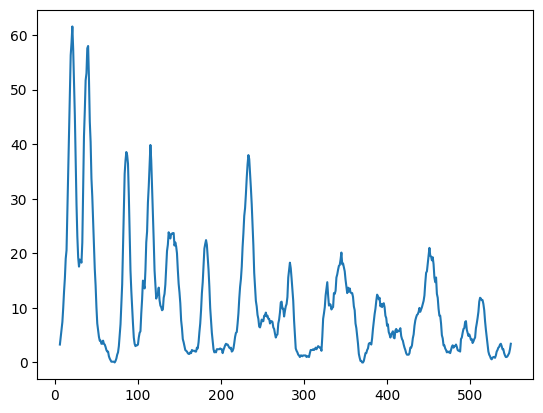

In [5]:
import pandas as pd

def moving_average(data, window_size):
    return data.rolling(window=window_size).mean()

# Đọc dữ liệu từ file CSV
# df = pd.read_csv('data.csv', parse_dates=['timestamp'])
# df.set_index('timestamp', inplace=True)

ma_df = train_df.rename(columns= {"Influenza A - All types of surveillance": "case"})

# Áp dụng Moving Average Filter
window_size = 7  # Bạn có thể điều chỉnh kích thước cửa sổ tùy ý
ma_df['case_ma'] = moving_average(ma_df['case'], window_size)

# Lưu kết quả vào file CSV mới
# df.to_csv('data_ma.csv')
ma_df = ma_df.dropna()
zero_df = ma_df[ma_df['case_ma'] ==0]
ma_df['case_ma'].plot()
print(len(zero_df))


550


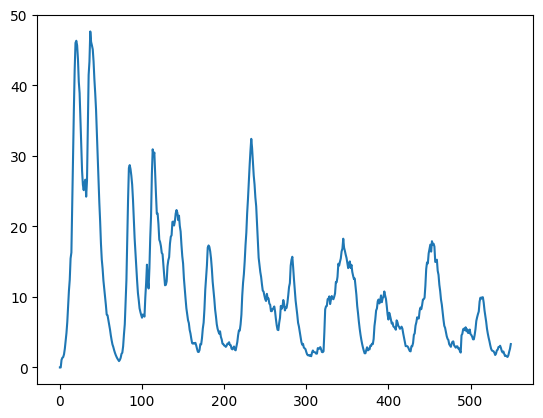

In [13]:
def exponential_moving_average(data, span):
    return data.ewm(span=span, adjust=False).mean()

ema_df = train_df.rename(columns= {"Influenza A - All types of surveillance": "case"})

# Áp dụng Exponential Moving Average
span = 12  # Bạn có thể điều chỉnh độ dài span tùy ý
ema_df['case_ema'] = exponential_moving_average(ema_df['case'], span)

ema_df['case_ema'].plot()
print(len(ema_df))
ema_df.to_csv('../temp_data/ema.csv', index=0)
#survey các hướng tiếp cận, outlier, mùa



<Axes: >

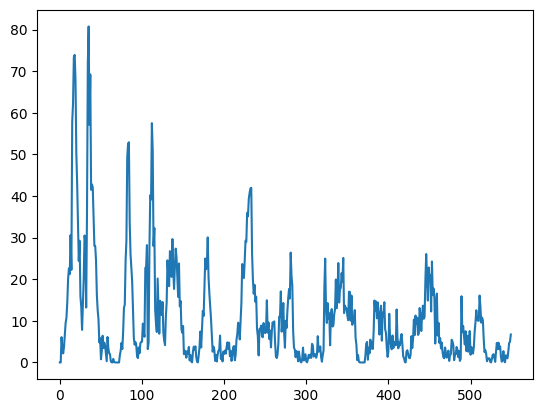

In [7]:
class OneEuroFilter:
    def __init__(self, min_cutoff=1.0, beta=0.0, d_cutoff=1.0):
        self.min_cutoff = min_cutoff
        self.beta = beta
        self.d_cutoff = d_cutoff
        self.x_prev = None
        self.dx_prev = None
        self.t_prev = None

    def __call__(self, x, t):
        if self.x_prev is None:
            self.x_prev = x
            self.dx_prev = 0.0
            self.t_prev = t
            return x

        dt = t - self.t_prev
        dx = (x - self.x_prev) / dt if dt > 0 else 0.0
        edx = self.alpha(dt, self.d_cutoff) * dx + (1 - self.alpha(dt, self.d_cutoff)) * self.dx_prev
        cutoff = self.min_cutoff + self.beta * abs(edx)
        x_hat = self.alpha(dt, cutoff) * x + (1 - self.alpha(dt, cutoff)) * self.x_prev

        self.x_prev = x_hat
        self.dx_prev = edx
        self.t_prev = t

        return x_hat

    @staticmethod
    def alpha(dt, cutoff):
        tau = 1.0 / (2 * 3.1416 * cutoff)
        return 1.0 / (1.0 + tau / dt)

one_eu_df = train_df.rename(columns= {"Influenza A - All types of surveillance": "case"})

# Áp dụng One Euro Filter
one_euro_filter = OneEuroFilter(min_cutoff=1.0, beta=0.01, d_cutoff=1.0)
one_eu_df['case_euro'] = [one_euro_filter(value, t) for t, value in one_eu_df['case'].items()]
one_eu_df['case_euro'].plot()

In [8]:
for t, value in one_eu_df['case'].items():
    print(t, value)

0 0.0
1 0.0
2 7.0
3 3.0
4 2.0
5 4.0
6 7.0
7 10.0
8 11.0
9 15.0
10 21.0
11 23.0
12 21.0
13 32.0
14 21.0
15 62.0
16 63.0
17 75.0
18 74.0
19 67.0
20 48.0
21 42.0
22 33.0
23 23.0
24 30.0
25 14.0
26 13.0
27 7.0
28 15.0
29 21.0
30 32.0
31 29.0
32 11.0
33 39.0
34 76.0
35 82.0
36 54.0
37 71.0
38 38.0
39 43.0
40 42.0
41 34.0
42 27.0
43 28.0
44 24.0
45 15.0
46 12.0
47 10.0
48 4.0
49 6.0
50 0.0
51 3.0
52 7.0
53 3.0
54 5.0
55 4.0
56 2.0
57 0.0
58 7.0
59 3.0
60 2.0
61 2.0
62 0.0
63 0.0
64 0.0
65 1.0
66 0.0
67 0.0
68 0.0
69 0.0
70 0.0
71 0.0
72 0.0
73 2.0
74 3.0
75 5.0
76 3.0
77 8.0
78 14.0
79 14.0
80 26.0
81 30.0
82 52.0
83 53.0
84 53.0
85 31.0
86 25.0
87 22.0
88 19.0
89 12.0
90 5.0
91 4.0
92 5.0
93 4.0
94 1.0
95 1.0
96 4.0
97 2.0
98 5.0
99 5.0
100 5.0
101 10.0
102 7.0
103 6.0
104 25.0
105 23.0
106 29.0
107 0.0
108 5.0
109 30.0
110 42.0
111 39.0
112 60.0
113 50.0
114 25.0
115 33.0
116 10.0
117 9.0
118 7.0
119 22.0
120 12.0
121 6.0
122 16.0
123 14.0
124 11.0
125 15.0
126 6.0
127 5.0
128 4.0
129 12.0